In [1]:
import hvsrpy

from obspy.clients.fdsn import Client
from obspy import UTCDateTime

import numpy as np
from scipy import stats

from matplotlib import pyplot as plt

In [2]:
'''IMPORT MODULES '''

from get_waveforms import get_waveforms
from get_hvsr import get_hvsr

In [3]:

'''Parameters to create hvsr object'''

# windowlength = 40

# Boolean to control whether Butterworth filter is applied. 
# Geopsy does not apply a bandpass filter.
filter_bool = False        
# Low-cut frequency for bandpass filter. Use 0.01 Hz for low pass
filter_flow_001 = 0.01                   
# High-cut frequency for bandpass filter.
filter_fhigh = 30                   
# Filter order.
filter_order = 5

# Width of cosine taper {0. - 1.}. Geopsy default of 0.05 is equal to 0.1 -> 0.1 is recommended
width = 0.1


"""FREQUENCY DOMAIN SETTING"""

# Konno and Ohmachi smoothing constant. 40 is recommended.
bandwidth = 40

# Minimum frequency after resampling; trying to push 0.01
resample_fmin_001 = 0.01
# Maximum frequency after resampling
resample_fmax = 50
# Number of frequencies after resampling
resample_fnum = 200
# Type of resampling {'log', 'linear'}
resample_type = 'log'

# Upper and lower frequency limits to restrict peak selection. To use the entire range use `None`.
peak_f_lower = None
peak_f_upper = None

"""HVSR Settings"""
bp_filter_001 = {"flag":filter_bool, "flow":filter_flow_001, "fhigh":filter_fhigh, "order":filter_order}
resampling_001 = {"minf":resample_fmin_001, "maxf":resample_fmax, "nf":resample_fnum, "res_type":resample_type}

# Method for combining horizontal components {"squared-average", "geometric-mean", "single-azimuth"}.
# Geopsy's default is "squared-average" -> "geometric-mean" is recommended.
method = "geometric-mean"
# If method="single-azimuth", set azimuth in degree clock-wise from north. If method!="single-azimuth", value is ignored.
azimuth = 0

# Boolean to control whether frequency domain rejection proposed by Cox et al. (2020) is applied.
# Geopsy does not offer this functionality.
rejection_bool = True
# Number of standard deviations to consider during rejection. Smaller values will reject more windows -> 2 is recommended.
n = 2
# Maximum number of iterations to perform for rejection -> 50 is recommended.
max_iterations = 50

# Distribution of f0 {"lognormal", "normal"}. Geopsy default "normal" -> "lognormal" is recommended.
distribution_f0 = "lognormal"
# Distribution of mean curve {"lognormal", "normal"}. Geopsy default "lognormal" -> "lognormal" is recommended.
distribution_mc = "lognormal"


## GET DATA FOR 2 HOURS, RIDGECREST 7.1

In [121]:
t= UTCDateTime('2019-07-06T03:19:53.000')
starttime = t - 1*3600
endtime = t + 1*3600
net = 'CI'
sta = 'USC'
loc = '*'
channel = ['HHE','HHN','HHZ']
client = 'IRIS'

usc_northridge2hr = get_waveforms(client=client, net=net, sta=sta, loc=loc, channel=channel, t=t, starttime=starttime, endtime=endtime)

In [122]:
ew_2 = usc_northridge2hr[0]
ns_2 = usc_northridge2hr[1]
vt_2 = usc_northridge2hr[2]


## GET DATA FOR *6 HOURS and 24 HOURS*, RIDGECREST 7.1

In [162]:
t= UTCDateTime('2019-07-06T03:19:53.000')

net = 'CI'
sta = 'USC'
loc = '*'
channel = ['HHE','HHN','HHZ']
client = 'IRIS'

usc_northridge2hr = get_waveforms(client=client, net=net, sta=sta, loc=loc, channel=channel, t=t, starttime=t-1*3600, endtime=t+1*3600)

usc_northridge6hr = get_waveforms(client=client, net=net, sta=sta, loc=loc, channel=channel, t=t, starttime=t-3*3600,
                                  endtime=t+3*3600)

usc_northridge24hr = get_waveforms(client=client, net=net, sta=sta, loc=loc, channel=channel, t=t, starttime = t-12*3600,
                                  endtime=t+12*3600)

# Extracinting time series components 
ew_2 = usc_northridge2hr[0]
ns_2 = usc_northridge2hr[1]
vt_2 = usc_northridge2hr[2]


ew_6 = usc_northridge6hr[0]
ns_6 = usc_northridge6hr[1]
vt_6 = usc_northridge6hr[2]


ew_24 = usc_northridge24hr[0]
ns_24 = usc_northridge24hr[1]
vt_24 = usc_northridge24hr[2]


In [161]:
def amp_hvsr(windows, ew, ns, vt, bp_filter, resampling):
    # Create a dictionary with different windows 
    # Return a dictionary that contains keys as number of peaks, values as corresponding standard deviation
    
    '''CREATE A SENSOR 3C OBJECT'''
    
    hvsr = hvsrpy.Sensor3c(ew=ew, ns=ns, vt=vt, meta=None)
    wi = {}
    for window in windows:
        wi[f"wi_{window}"] = hvsr.hv(windowlength=window, bp_filter=bp_filter, taper_width=width, bandwidth=bandwidth,
                                    resampling=resampling, method=method, f_low=None,f_high=None, azimuth=None)
    
    # Calculate standard deviation of amplitudes 
    std_wi = {}
    for hvsr in wi.values():
        lst = [hvsr.amp]
        # Number of peaks 
        num_peaks = len(hvsr.amp) 

        std_wi[f"num_wi{num_peaks}"] = np.std(lst)

        del lst 

    
 
    return std_wi

In [190]:
windows_2 = np.arange(300, 1000, 100)
std_wi_2hr = amp_hvsr(windows=windows_2, ew=ew_2, ns=ns_2, vt=vt_2, bp_filter=bp_filter_001, resampling=resampling_001)


In [191]:
windows_6 = np.arange(300, 2000, 100)
std_wi_6hr = amp_hvsr(windows=windows_6, ew=ew_6, ns=ns_6, vt=vt_6, bp_filter=bp_filter_001, resampling=resampling_001)

In [193]:
windows_24 = np.arange(300, 5000, 100)
std_wi_24hr = amp_hvsr(windows=windows_24, ew=ew_24, ns=ns_24, vt=vt_24, bp_filter=bp_filter_001, resampling=resampling_001)

In [195]:
windows2_01 = np.arange(40,640,20)
std_2hr_01 = amp_hvsr(windows=windows2_01, ew=ew_2, ns=ns_2, vt=vt_2, bp_filter=bp_filter_01, resampling=resampling_01)

In [212]:
windows6_01 = np.arange(40, 1600, 100)
std_6hr_01 = amp_hvsr(windows=windows6_01, ew=ew_6, ns=ns_6, vt=vt_6, bp_filter=bp_filter_001, resampling=resampling_001)

C:\Users\kickk\AppData\Roaming\Python\Python38\site-packages\sigpropy\timeseries.py:267: UserWarning: nseries > 1, so joining before splitting.
  warnings.warn("nseries > 1, so joining before splitting.")


In [219]:
windows24_01 = np.arange(40, 2200, 80)
std_24hr_01 = amp_hvsr(windows=windows24_01, ew=ew_6, ns=ns_6, vt=vt_6, bp_filter=bp_filter_001, resampling=resampling_001)

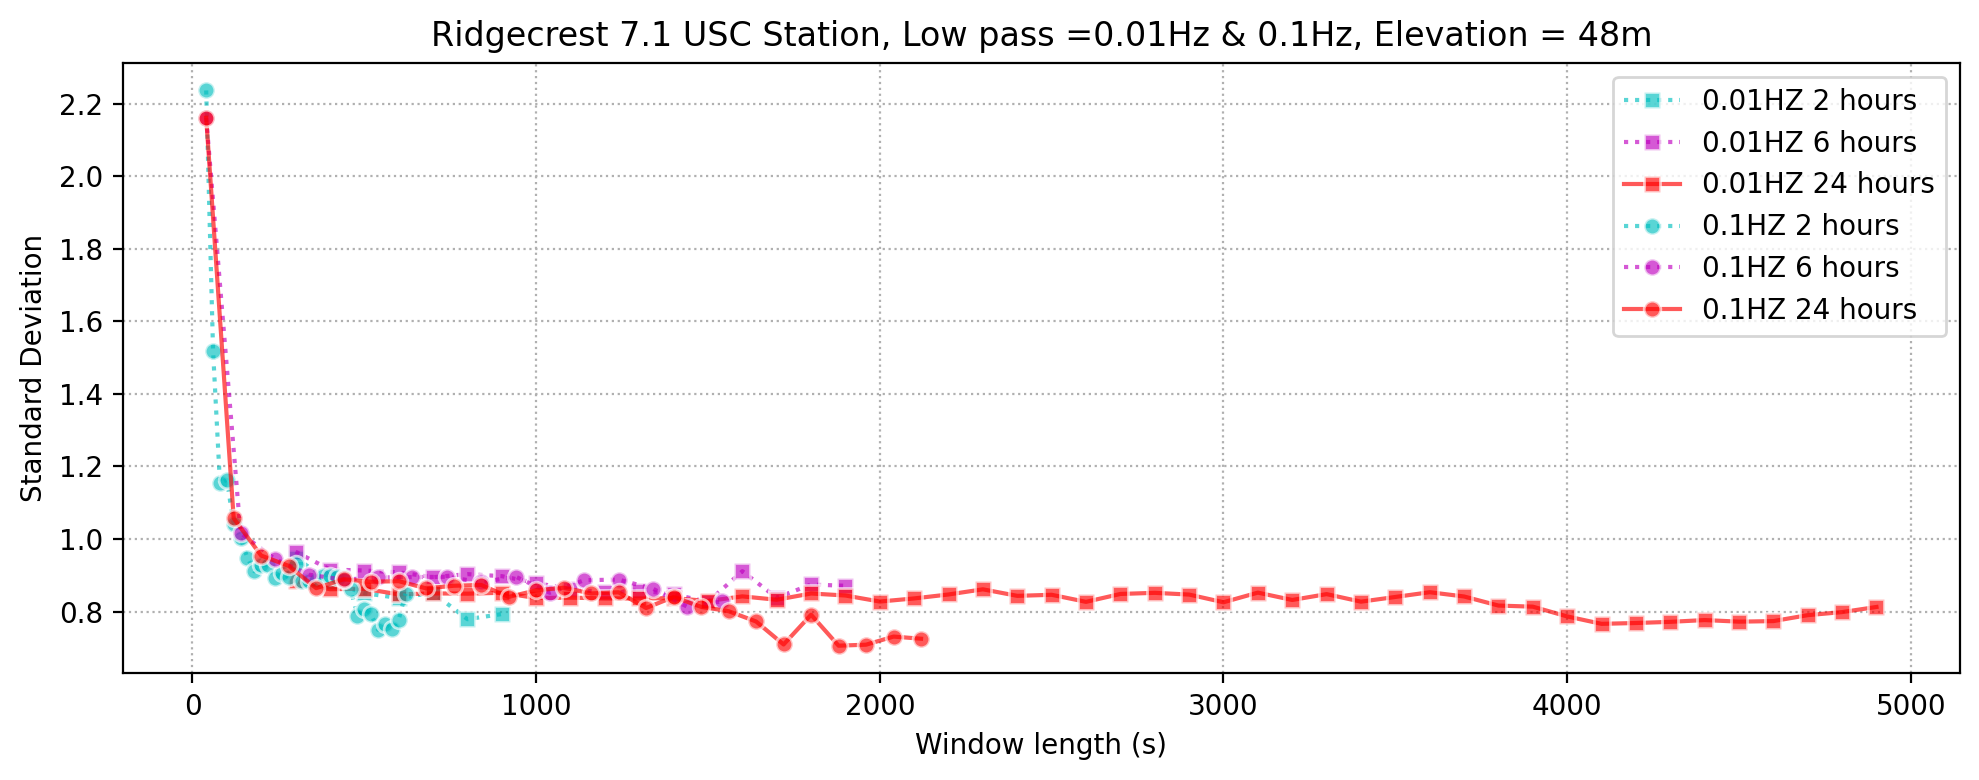

In [223]:
fig, ax = plt.subplots(figsize=(10,4), dpi =200)
# Size figure

# Low pass 0.01 Hz
ax.plot(windows_2, std_wi_2hr.values(), linestyle=':', color = 'c', marker = 's', markeredgecolor ='white', label='0.01HZ 2 hours',
       alpha = 0.65)
ax.plot(windows_6, std_wi_6hr.values(), linestyle='dotted', color = 'm', marker = 's', markeredgecolor ='white', label='0.01HZ 6 hours',
       alpha = 0.65)
ax.plot(windows_24, std_wi_24hr.values(), linestyle='-', color = 'r', marker = 's', markeredgecolor ='white', label='0.01HZ 24 hours',
       alpha = 0.65)
# LOW PASS 0.1 HZ
ax.plot(windows2_01, std_2hr_01.values(), linestyle=':', color = 'c', marker = 'o', markeredgecolor ='white', label='0.1HZ 2 hours',
       alpha = 0.65)
ax.plot(windows6_01, std_6hr_01.values(), linestyle='dotted', color = 'm', marker = 'o', markeredgecolor ='white', label='0.1HZ 6 hours',
       alpha = 0.65)
ax.plot(windows24_01, std_24hr_01.values(), linestyle='-', color = 'r', marker = 'o', markeredgecolor ='white', label='0.1HZ 24 hours',
       alpha = 0.65)

# Setting axes scale
ax.set_xscale('linear')

plt.title('Ridgecrest 7.1 USC Station, Low pass =0.01Hz & 0.1Hz, Elevation = 48m')

ax.set_xlabel('Window length (s)')
ax.set_ylabel('Standard Deviation')

# Set labels by calling ax.legend()
ax.legend()

# Set grid

plt.grid(which = 'both', axis = 'both', linestyle=':')

## SAVE FIGURE

fname = 'C:/University of Southern California Education/Research/HVSR/Figures/RC_71_Stdv_001hz.jpg'
plt.tight_layout()

plt.savefig(fname = fname, dpi=600, bbox_inches='tight')

plt.show()


In [147]:

'''Parameters to create hvsr object'''

# windowlength = 40

# Boolean to control whether Butterworth filter is applied. 
# Geopsy does not apply a bandpass filter.
filter_bool = False        
# Low-cut frequency for bandpass filter. Use 0.01 Hz for low pass
filter_flow_01 = 0.1                   
# High-cut frequency for bandpass filter.
filter_fhigh = 30                   
# Filter order.
filter_order = 5

# Width of cosine taper {0. - 1.}. Geopsy default of 0.05 is equal to 0.1 -> 0.1 is recommended
width = 0.1


"""FREQUENCY DOMAIN SETTING"""

# Konno and Ohmachi smoothing constant. 40 is recommended.
bandwidth = 40

# Minimum frequency after resampling; trying to push 0.01
resample_fmin_01 = 0.1
# Maximum frequency after resampling
resample_fmax = 50
# Number of frequencies after resampling
resample_fnum = 200
# Type of resampling {'log', 'linear'}
resample_type = 'log'

# Upper and lower frequency limits to restrict peak selection. To use the entire range use `None`.
peak_f_lower = None
peak_f_upper = None

"""HVSR Settings"""
bp_filter_01 = {"flag":filter_bool, "flow":filter_flow_01, "fhigh":filter_fhigh, "order":filter_order}
resampling_01 = {"minf":resample_fmin_01, "maxf":resample_fmax, "nf":resample_fnum, "res_type":resample_type}

# Method for combining horizontal components {"squared-average", "geometric-mean", "single-azimuth"}.
# Geopsy's default is "squared-average" -> "geometric-mean" is recommended.
method = "geometric-mean"
# If method="single-azimuth", set azimuth in degree clock-wise from north. If method!="single-azimuth", value is ignored.
azimuth = 0

# Boolean to control whether frequency domain rejection proposed by Cox et al. (2020) is applied.
# Geopsy does not offer this functionality.
rejection_bool = True
# Number of standard deviations to consider during rejection. Smaller values will reject more windows -> 2 is recommended.
n = 2
# Maximum number of iterations to perform for rejection -> 50 is recommended.
max_iterations = 50

# Distribution of f0 {"lognormal", "normal"}. Geopsy default "normal" -> "lognormal" is recommended.
distribution_f0 = "lognormal"
# Distribution of mean curve {"lognormal", "normal"}. Geopsy default "lognormal" -> "lognormal" is recommended.
distribution_mc = "lognormal"


## AMBIENT NOISE 2021-11-26 FROM 3 AM; 2-HR DATA

In [142]:
t= UTCDateTime('2021-11-26T03:19:53.000')
starttime = t - 1*3600
endtime = t + 1*3600
net = 'CI'
sta = 'USC'
loc = '*'
channel = ['HHE','HHN','HHZ']
client = 'IRIS'

usc_northridge2hr = get_waveforms(client=client, net=net, sta=sta, loc=loc, channel=channel, t=t, starttime=starttime, endtime=endtime)

usc_northridge6hr = get_waveforms(client=client, net=net, sta=sta, loc=loc, channel=channel, t=t, starttime=t-3*3600,
                                  endtime=t+3*3600)

usc_northridge24hr = get_waveforms(client=client, net=net, sta=sta, loc=loc, channel=channel, t=t, starttime = t-12*3600,
                                  endtime=t+12*3600)

ew_2 = usc_northridge2hr[0]
ns_2 = usc_northridge2hr[1]
vt_2 = usc_northridge2hr[2]

ew_6 = usc_northridge6hr[0]
ns_6 = usc_northridge6hr[1]
vt_6 = usc_northridge6hr[2]


ew_24 = usc_northridge24hr[0]
ns_24 = usc_northridge24hr[1]
vt_24 = usc_northridge24hr[2]

In [151]:
windows = np.arange(40,600,20)
am_wi2hr = amp_hvsr(windows=windows, ew=ew_2, ns=ns_2, vt=vt_2, bp_filter=bp_filter_01, resampling=resampling_01)

In [155]:
windows = np.arange(40,1000,20)
am_wi6hr = amp_hvsr(windows=windows, ew=ew_6, ns=ns_6, vt=vt_6, bp_filter=bp_filter_01, resampling=resampling_01)

In [158]:
windows = np.arange(40,1600,20)
am_wi24hr = amp_hvsr(windows=windows, ew=ew_24, ns=ns_24, vt=vt_24, bp_filter=bp_filter_01, resampling=resampling_01`)

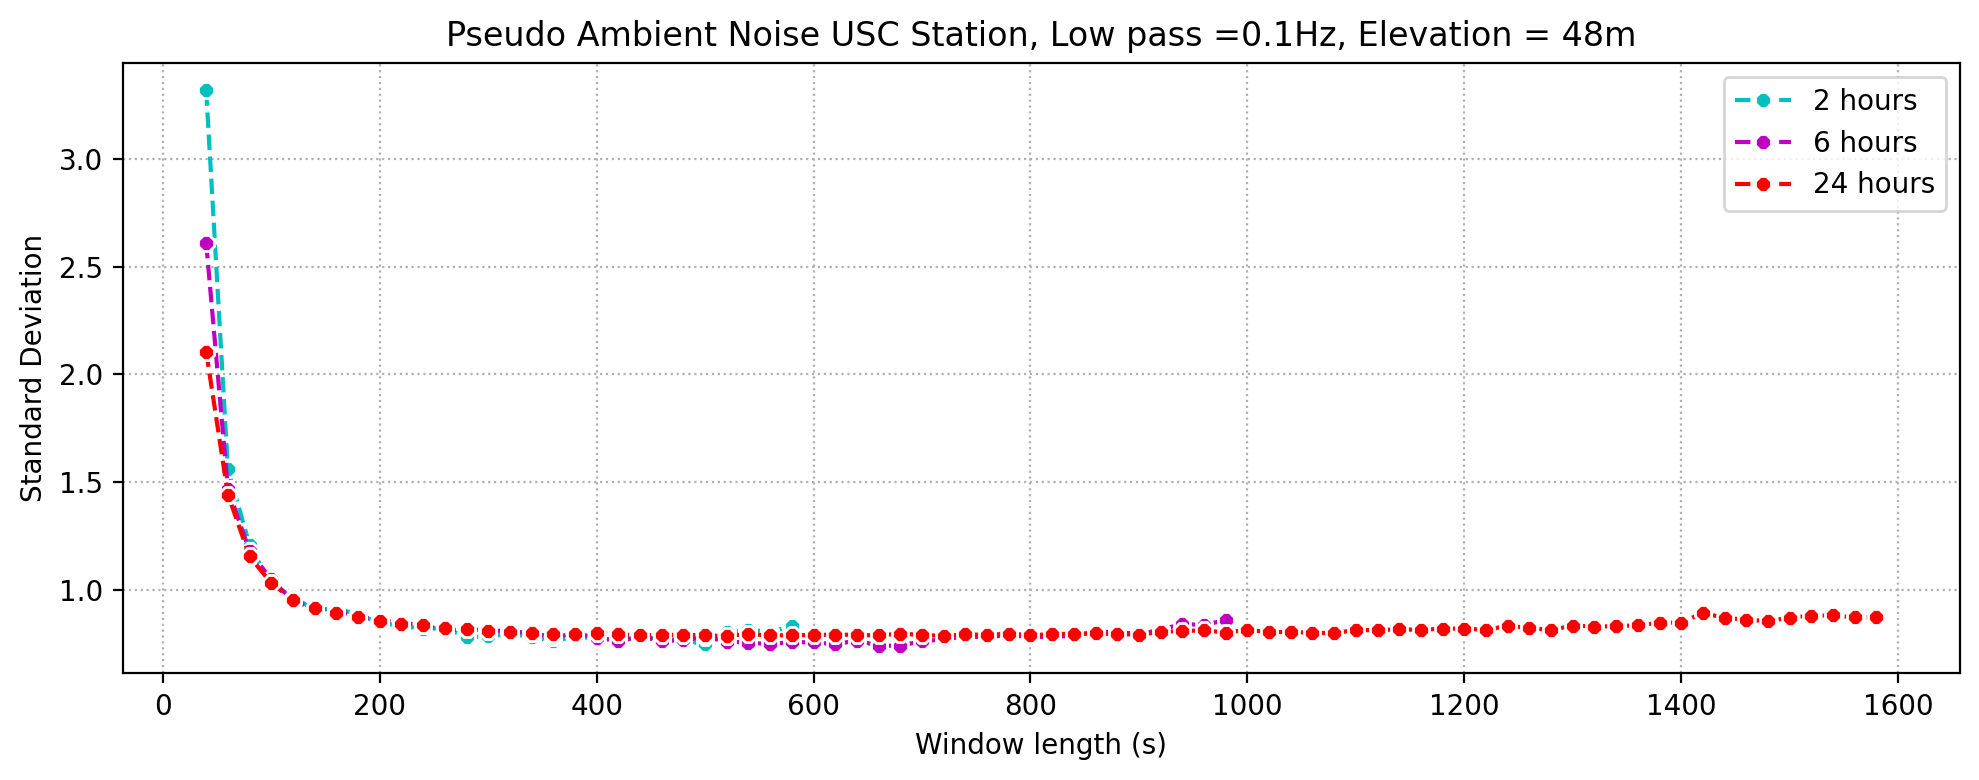

In [160]:
fig, ax = plt.subplots(figsize=(10,4), dpi =200)
# Size figure
windows_2 = np.arange(40,600,20)
windows_6 = np.arange(40,1000,20)
windows_24 = np.arange(40,1600,20)

ax.plot(windows_2, am_wi2hr.values(), linestyle='--', color = 'c', marker = '8', markeredgecolor ='white', label='2 hours')
ax.plot(windows_6, am_wi6hr.values(), linestyle='--', color = 'm', marker = '8', markeredgecolor ='white', label='6 hours')
ax.plot(windows_24, am_wi24hr.values(), linestyle='--', color = 'r', marker = '8', markeredgecolor ='white', label='24 hours')


# Setting axes scale
ax.set_xscale('linear')

plt.title('Pseudo Ambient Noise USC Station, Low pass =0.1Hz, Elevation = 48m')

ax.set_xlabel('Window length (s)')
ax.set_ylabel('Standard Deviation')

# Set labels by calling ax.legend()
ax.legend()

# Set grid

plt.grid(which = 'both', axis = 'both', linestyle=':')

## SAVE FIGURE

fname = 'C:/University of Southern California Education/Research/HVSR/Figures/RC_71_Stdv_01hz.jpg'
plt.tight_layout()

plt.savefig(fname = fname, dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
fig, ax = plt.subplots(dpi=400)

# ax.plot(usc_noridge_hvsr.frq, usc_noridge_hvsr.amp, color='c', linewidth=0.5)
'''Ignore 0 division'''
np.seterr(invalid='ignore')



ax.plot(wi_500.frq, wi_500.mean_curve(distribution="lognormal"), color='k', linewidth=1, label='windowlength = 5000')



# ax.plot([usc_noridge_hvsr.mean_f0_frq(distribution_f0)]*2, [_ymin, _ymax], linestyle="-.", color="#000000")

ax.legend()
# Setting axis scale
ax.set_xscale('log')
ax.set_yscale('linear')

# Setting axes title
ax.set_xlabel('Frequency (HZ)')
ax.set_ylabel('Mean H/V Amplitude')
# ax.plot([usc_noridge_hvsr.mean_f0_frq('lognormal')]*2, [_ymin, _ymax], linestyle="-.", color="#000000")
plt.grid(which='both', axis='both')
plt.show()

In [7]:
del hvsr60, hvsr